$\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\vu}{{\bf u}}
\newcommand{\ve}{{\bf e}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mi}{{\bf I}}
\newcommand{\diag}{\mbox{diag}}
\newcommand{\begeq}{{\begin{equation}}}
\newcommand{\endeq}{{\end{equation}}}
$


# Newton's Method in Multiple Precision: C. T. Kelley

This document has two purposes.

1. To document the SIREV paper <cite data-cite="ctk:sirev19"><a href="newtonmp.html#ctk:sirev19">(Kel19)</cite>

2. To show the RTG people how to do some non-trivial work in Julia and put some LaTeX in their notebooks.

As an example we will solve the Chandrasekhar H-equation <cite data-cite="chand"><a href="newtonmp.html#chand">(Cha60)</cite>. This equation, which we describe in detail in the Example section, has a fast $O(N \log(N))$ function evaluation, a Jacobian evaluation that is $O(N^2)$ work analytically and $O(N^2 \log(N))$ with a finite difference. This means that most of the work, if you do things right, is in the LU factorization of the Jacobian. 
    
The difference between double, single, and half precision will be clear in the results from the examples.



## The Chandresekhar H-Equation

The example is the mid-point rule discretization of the Chandrsekhar H-equation <cite data-cite="chand"><a href="newtonmp.html#chand">(Cha60)</cite>.
    
    
 
   \begin{equation}
    {\calf}(H)(\mu) = H(\mu) -
\left(
1 - \frac{c}{2} \int_0^1 \frac{\mu H(\mu)}{\mu + \nu} \dnu
\right)^{-1} = 0.
    \end{equation}
    
    
The nonlinear operator $\calf$ is defined on $C[0,1]$, the space of
continuous functions on $[0,1]$.  

The equation has a well-understood dependence on the parameter $c$
<cite data-cite="twm68"><a href="newtonmp.html#twm68">(Mul68)</cite>,
    <cite data-cite="ctk:n1"><a href="newtonmp.html#ctk:n1">(DK80)</cite>.
The equation has unique solutions at $c=0$
and $c=1$ and two solutions for $0 < c < 1$. There is a simple fold
singularity 
        <cite data-cite="herb"><a href="newtonmp.html#herb">(Kel87)</cite>
        at $c=1$. Only one 
        <cite data-cite="chand"><a href="newtonmp.html#chand">(Cha60)</cite>,
        <cite data-cite="busb"><a href="newtonmp.html#busb">(Bus60)</cite>
            of the two solutions for $0 < c < 1$ is of physical interest
and that is the one easiest to find numerically. One must do
a continuation computation to find the other one.

The structure of the singularity is preserved if one discretizes
the integral with any rule that integrates constants exactly. For
the purposes of this paper the composite midpoint rule will suffice.
The $N$-point composite midpoint rule is
\begin{equation}
\int_0^1 f(\nu) \dnu \approx \frac{1}{N} \sum_{j=1}^N f(\nu_j)
\end{equation}
where $\nu_j = (j - 1/2)/N$ for $1 \le j \le N$. This rule is
second-order accurate for sufficiently smooth functions $f$. The
solution of the integral equation is, however, not smooth enough. $H'(\mu)$
has a logarithmic singularity at $\mu=0$.

The discrete problem is

\begin{equation}
\mf(\vu)_i \equiv
u_i - \left(
1  - \frac{c}{2N} \sum_{j=1}^N \frac{u_j \mu_i}{\mu_j + \mu_i}
\right)^{-1}
=0.
\end{equation}

One can simplify the approximate integral operator in \eqnok{hmid}
and expose some useful structure. Since


\begin{equation}
\frac{c}{2N} \sum_{j=1}^N \frac{u_j \mu_i}{\mu_j + \mu_i}
= \frac{c (i - 1/2) }{2N} \sum_{j=1}^N \frac{u_j}{i+j -1}.
\end{equation}


hence the approximate integral operator is
the product of a diagonal matrix and a Hankel matrix and
one can use an FFT to evaluate that operator with $O(N \log(N))$
work 
<cite data-cite="golub"><a href="newtonmp.html#golub">(GV96)</cite>.
    
We can express the approximation of the integral operator in matrix
form
\begin{equation}
\ml(\vu)_i = \frac{c (i - 1/2) }{2N} \sum_{j=1}^N \frac{u_j}{i+j -1}
\end{equation}
and compute the Jacobian analytically as
\begin{equation}
\mf'(\vu) = \mi - \diag(\mg(\vu))^2 \ml
\end{equation}
where
\begin{equation}
\mg(\vu)_i = \left(
1  - \frac{c}{2N} \sum_{j=1}^N \frac{u_j \mu_i}{\mu_j + \mu_i}
\right)^{-1}.
\end{equation}
Hence the data for the Jacobian is already available after
one computes $\mf(\vu) = \vu - \mg(\vu)$ and the Jacobian can
be computed with $O(N^2)$ work.
We do that in this example and therefore the only $O(N^3)$
part of the solve is the matrix factorization.

One could also approximate the Jacobian with forward differences.
In this case one approximates the $j$th column $\mf'(\vu)_j$
of the Jacobian with
\begin{equation}
\frac{\mf(\vu + h {\tilde \ve}_j) - \mf(\vu)}{h}
\end{equation}
where ${\tilde \ve}_j$ is a unit vector in the $j$th coordinate
direction and $h$ is a suitable difference increment. If one computes
$\mf$ in double precision with unit roundoff $u_d$, then
$h =O(\| \vu \| \sqrt{u_d})$ is a reasonable choice 
<cite data-cite="ctk:roots"><a href="newtonmp.html#ctk:roots">(Kel95)</cite>.
Then
the error in the Jacobian is $O(\sqrt{u_d}) = O(u_s)$ where $u_s$ is
unit roundoff in single precision. The cost of a finite difference Jacobian
in this example is $O(N^2 \log(N))$ work.

The analysis in  <cite data-cite="ctk:sirev19"><a href="newtonmp.html#ctk:sirev19">(Kel19)</cite> suggests that there
is no significant difference in the nonlinear iteration
from either the choice of analytic or finite difference Jacobians
or the choice of single or double precision for the linear solver. This notebook has the data used in that paper
to support that assertion. You will be able to duplicate the results and play with the codes.
    
Half precision is another story and we have those codes for you, too.
    


## Setting up

You need to install these packages:

- PyPlot
- LinearAlgebra
- JLD2
- Printf
- FFTW
- IJulia (You must have done this already or you would not be looking at this notebook.)
- AbstractFFTs

The directory is a Julia project. So all you should need to do to get going is to

1. Put the directory in your LOAD_PATH. The way to do this is to type
```Julia
push!(LOAD_PATH,"/Users/yourid/whereyouputit/MPResults2019")
```
at the Julia prompt in the REPL or in a notebook code windown.

2. Now load the modules with
```Julia
using MPResults2019
```

3. Then you can do a simple solve and test that you did it right by typing
```Julia
hout=heqtest()
```
which I will do now. Make sure __MPResults2019__ is in your LOAD_PATH! If you forget to do the push! command, strange things may happen.



In [17]:
push!(LOAD_PATH,"/Users/ctk/Dropbox/Julia/MPResults2019")
using MPResults2019


In [18]:
heqtest()

0.00e+00      1.00000e+00 
5.00e-02      1.04424e+00 
1.00e-01      1.07236e+00 
1.50e-01      1.09470e+00 
2.00e-01      1.11346e+00 
2.50e-01      1.12965e+00 
3.00e-01      1.14389e+00 
3.50e-01      1.15657e+00 
4.00e-01      1.16797e+00 
4.50e-01      1.17830e+00 
5.00e-01      1.18773e+00 
5.50e-01      1.19638e+00 
6.00e-01      1.20435e+00 
6.50e-01      1.21172e+00 
7.00e-01      1.21856e+00 
7.50e-01      1.22493e+00 
8.00e-01      1.23088e+00 
8.50e-01      1.23646e+00 
9.00e-01      1.24169e+00 
9.50e-01      1.24662e+00 
1.00e+00      1.25126e+00 

 
 
[1.54457e+00, 7.94167e-03, 1.55209e-07, 2.39149e-15, 1.61651e-15, 1.36877e-15, 1.47288e-15, 1.76242e-15, 2.20932e-15, 1.50598e-15, 1.06489e-15]


(exactout = (solution = [1.00707e+00; 1.01754e+00; … ; 1.24989e+00; 1.25081e+00], ithist = [1.54457e+00, 7.94167e-03, 1.55209e-07, 2.39149e-15, 1.61651e-15, 1.36877e-15, 1.47288e-15, 1.76242e-15, 2.20932e-15, 1.50598e-15, 1.06489e-15]), fdout = (solution = [1.00707e+00; 1.01754e+00; … ; 1.24989e+00; 1.25081e+00], ithist = [1.54457e+00, 7.94166e-03, 1.55234e-07, 2.02292e-15, 1.40433e-15, 1.29473e-15, 1.47288e-15, 1.52226e-15, 1.27555e-15, 1.43901e-15, 1.38667e-15]))

heqtest.jl, calls the solver and harvests some iteration statistics. The two columns of numbers are the reults from <cite data-cite="chand"><a href="newtonmp.html#chand">(Cha60)</cite> (page 125). The iteration statistics are from KNL, the solver.

##  KNL

The solver is _knl.jl_ version .01. Keep in mind that nothing with a version number with a negative exponent field is likely to be very good. knl.jl is included when you run the MPResults2019.jl module, which you do automatically when you
type __using MPResults2019__


knl.jl is a simple implemention of Newton's method (see 
<cite data-cite="ctk:roots"><a href="newtonmp.html#ctk:roots">(Kel95)</cite> and
<cite data-cite="ctk:newton"><a href="newtonmp.html#ctk:newton">(Kel03)</cite> )
using an LU factorization of the Jacobian to compute the Newton step with no line search or globalization. The code evaluates and factors the Jacobian at every nonlinear iteration.

Compare this with the scalar code with talked about last time.

## Using knl.jl ##

At the level of this notebook, it's pretty simple. Remember that Julia hates to allocate mememory. So your function and Jacobian evaluation routines should expect the calling function to **preallocate** the storage for both the function and Jacobian. Your functions will then use __.=__ to put the function and Jacobian where they are supposed to be.

It's worthwhile to look at the help screen. 

It's worth asking for help with knl ....

In [19]:
?knl

search: knl plotknl installkernel



```
knl(x, FS, FPS, F!, J!=diffjac!; rtol=1.e-6, atol=1.e-12, 
        maxit=20, dx=1.e-6, pdata=nothing)
```

This is Version .01. Nothing with a version number having a negative exponent field can be trusted.

Nonlinear solvers from my books in Julia. This version has no globalization, no quasi-Newton methods, and no Newton-Krylov. The mission here is to  duplicate the mixed precision results in my SIREV-ED submission.

# Inputs:

  * x: initial iterate
  * FS: Preallcoated storage for function. It is an N x 1 column vector
  * FPS: preallcoated storage for Jacobian. It is an N x N matrix
  * F!: function evaluation, the ! indicates that F! overwrites FS, your   preallocated storage for the function.
  * J!: Jacobian evaluation, the ! indicates that J! overwrites FPS, your   preallocated storage for the Jacobian. If you leave this out the   default is a finite difference Jacobian.

---

# keyword arguments (kwargs):

  * rtol and atol: relative and absolute error tolerances
  * maxit: limit on nonlinear iterations
  * dx: difference increment in finite-difference derivatives     h=dx*norm(x)+1.e-8
  * pdata: precomputed data for the function/Jacobian.       Things will go better if you use this rather than hide the data       in global variables within the module for your function/Jacobian

---

# Using knl.jl

Here are the rules as of June 6, 2019

F! is the nonlinear residual.  J! is the Jacobian evaluation.

Put these things in a module and cook it up so that

1. You allocate storage for the function and Jacobian in advance  –> in the calling program <– NOT in FS and FPS

FV=F!(FV,x) returns FV=F(x)

FP=J!(FV,FP,x) returns FP=F'(x);      (FV,FP, x) must be the argument list, even if FP does not need FV.     One reason for this is that the finite-difference Jacobian     does and that is the default in the solver.

In the future J! will also be a matrix-vector product and FPS will be the PREALLOCATED (!!) storage for the GMRES(m) Krylov vectors.

Lemme tell ya 'bout precision. I designed this code for full precision functions and linear algebra in any precision you want. You can decleare FPS as Float64, Float32, or Float16 and knl will do the right thing if  YOU do not destroy the declaration in your J! function. I'm amazed  that this works so easily. 

If the Jacobian is reasonably well conditioned, I can see no reason to do linear algebra in double precision

Don't try to evaluate function and Jacobian all at once because  that will cost you a extra function evaluation everytime the line search kicks in.

2. Any precomputed data for functions, Jacobians, matrix-vector products may live in global variables within the module. Don't do that if you can avoid it. Use pdata instead.


## How knl.jl controls the precision of the Jacobian##

You can control the precision of the Jacobian by simply allocating FPS in your favorite precision. So if I have a problem with N=256 unknows I will decalare FP as zeros(N,1) and may delcare FPS as zeros(N,N) or Float32.(zeros(N,N)).

Note the __.__ between Float32 and the paren. This, as is standard Julia practice, applies the conversion to Float32 to everyelement in the array. If you forget the __.__ Julia will complain.

# The results in the paper

The paper has plots for double, single, and half precsion computations for c=.5, .99, and 1.0. The half precision results take a very long time to get. On my computer (2019 iMac; 8 cores, 64GB of memoroy) the half precision compute time was over two weeks. Kids, don't try this at home.

The data for the paper are in the cleverly named directory __Data_From_Paper__

__cd to the directory MPResults2019__ and __from that directory__ run

```Julia
data_harvest("Data_From_Paper/MP_Data_") 
```

at the julia prompt you will generate all the tables and plots in the paper.

If you have the time and patience you can also generate the data with data_populate.jl. This create three directories named Mixed_Precision_c=? and you can see for yourself. Look at that file to see opportunities to edit the time-cosumng jobs out. If you eliminate the half precision work and the larger dimensions, the code will run in a short time. 

Here is a simple example of using data_populate and the plotter code plot_knl.jl. I'm only using the 1024, 2048 and 4096 point grids. The plot in the paper uses more levels. This is part of Figure 1 in the paper.

Look at the source to __data_populate.jl__ and __plotknl.jl__ and you'll see how I did this. These codes only mange files, plots, and tables. There is nothing really exciting here. You don't need to know much Julia to understand this, but you do need to know something and I can't help with that.

To begin with, I will create a directory called Data_Test to put all this stuff. I will cd to that directory.

In [20]:
Home4mp="Data_Test"
try (mkdir(Home4mp))
catch
end
cd(Home4mp)
pwd()

"/Users/ctk/Dropbox/Julia/dev/MPResults2019/Data_Test/Mixed_Precision_c=5/Data_Test"

Now I'll run **data_populate** to create a subdirectory with the data. cd to that directory and run __plotknl__. That's how I created the plots in the paper with all values of *c* and all the problem sizes. The half precision computation took two weeks.

In [21]:
using PyPlot
data_populate(.5;half="no",level=3)

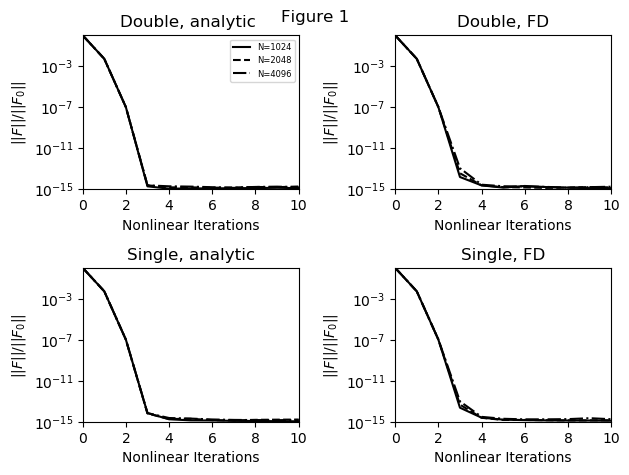

In [22]:
cd("Mixed_Precision_c=5")
figtitle="Figure 1"
plotknl("no",.5,10,3;bigtitle=figtitle)
cd("..")


__data_populate__ will create directories for your data if they are not already there. Run __plot_knl__ from one of those directories and it makes the plots. As you can see from the one above, it's hard to tell the difference between double and single precision linear algebra and analytic or finite difference Jacobians. You knew that.